<h1 style="text-align:center;font-size:30px;" >Emotion Detection</h1>

<h1>1. Libraries Load</h1> 

In [12]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from PIL import Image
import matplotlib.image as mpimg


In [13]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
from torch.nn import functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [14]:
from glob import glob
import random
import skimage
from PIL import Image
import os
import pandas as pd
from sklearn.model_selection import train_test_split

<h1>2. Loading Images Data</h1>  

In [16]:
IMAGE_DIR = 'ExpressionData/'

In [17]:
# Reading names of the images to further diivide them into test, train and validation
files = glob(IMAGE_DIR+"*.tiff")
if(len(files) < 1):
    print("No file found")
else:
    print(len(files) ,"files found")
    
File_df= pd.DataFrame()
File_df['File_name'] = pd.Series(files)
File_df['class'] = File_df['File_name'].apply(lambda x: x.split('.')[1][:2])

213 files found


In [24]:
print("Total number of images in the dataset:",len(files))

Total number of images in the dataset: 213


<h2>2.1 Display image data</h2>  

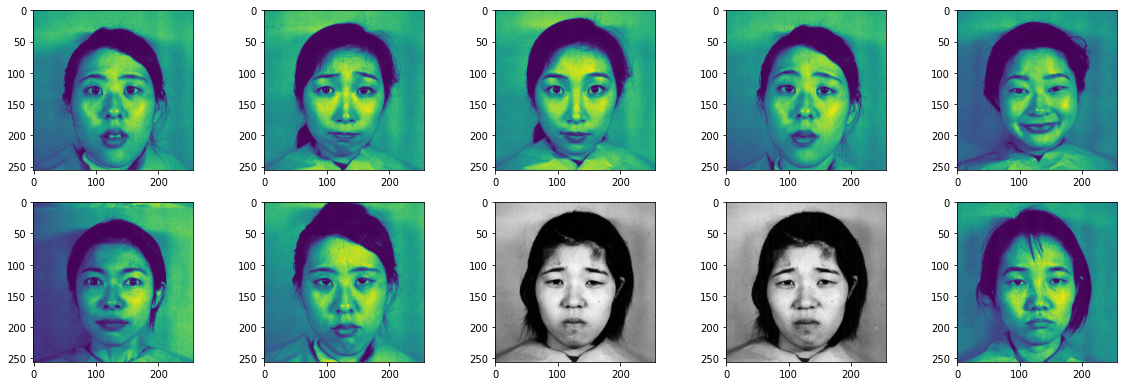

In [21]:
images = []
for img_path in files[0:10]:
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5
for i, image in enumerate(images):
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)

<h1> 3. Randomly Splitting files into test, train , val set </h1>

<p> Here we have used the train_test_split function to split the data into Train, Vaidlation and Test dataset </p>

In [25]:
#train_df, val_df, test_df = np.split(File_df.sample(frac=1), [int(.6*len(File_df)), int(.8*len(File_df))])
train_df, val_df, test_df = np.split(File_df.sample(frac=1), [int(.6*len(File_df)), int(.8*len(File_df))])

train_df,test_df,class_train,class_test  = train_test_split(File_df['File_name'],File_df['class'],test_size=0.2,train_size=0.8)
train_df, val_df, class_train, class_val = train_test_split(train_df,class_train,test_size = 0.25,train_size =0.75)

In [28]:
print("No of images in Train dataset:", train_df.shape[0])
print("No of images in Val dataset:", val_df.shape[0])
print("No of images in Test dataset:",test_df.shape[0])

No of images in Train dataset: 127
No of images in Val dataset: 43
No of images in Test dataset: 43


<h1>4. Defining The Classes of Imotions in the dataset</h1>

In [29]:
#dictionary to define various emotions
classes = {
    'HA': 0,
 'SA': 1,
 'SU': 2,
 'AN': 3,
 'DI': 4,
 'FE': 5,
 'NE': 6
}



<p>
Making the train, test, and validation folder empty so that new divided data can be copied into these folders
Do not run this step if need to generate the same results as reported
</p>

In [30]:

# for i in ['train','test','val']:
#     del_files = glob('data/'+i+'/*')
#     for f in del_files:
#         print(f)
#         os.remove(f)

In [629]:
"""
Copy the divided set of images names of images into test, train and validation
"""

import shutil, os    
for i,j in zip( [train_df,test_df,val_df], ['data/train/','data/test/','data/val/']):
    for f in i:
        print(f)
        shutil.copy(f,j)
    

/home/arshdeep/workspace/temp/ExpressionData/KR.NE2.72.tiff
/home/arshdeep/workspace/temp/ExpressionData/TM.DI2.194.tiff
/home/arshdeep/workspace/temp/ExpressionData/NM.FE1.110.tiff
/home/arshdeep/workspace/temp/ExpressionData/KM.FE3.25.tiff
/home/arshdeep/workspace/temp/ExpressionData/KL.DI4.173.tiff
/home/arshdeep/workspace/temp/ExpressionData/KM.NE3.3.tiff
/home/arshdeep/workspace/temp/ExpressionData/KA.AN3.41.tiff
/home/arshdeep/workspace/temp/ExpressionData/NM.NE1.92.tiff
/home/arshdeep/workspace/temp/ExpressionData/KR.HA2.75.tiff
/home/arshdeep/workspace/temp/ExpressionData/YM.FE4.70.tiff
/home/arshdeep/workspace/temp/ExpressionData/MK.DI2.129.tiff
/home/arshdeep/workspace/temp/ExpressionData/KL.FE2.175.tiff
/home/arshdeep/workspace/temp/ExpressionData/KA.FE2.46.tiff
/home/arshdeep/workspace/temp/ExpressionData/KM.DI1.20.tiff
/home/arshdeep/workspace/temp/ExpressionData/NA.FE1.217.tiff
/home/arshdeep/workspace/temp/ExpressionData/UY.NE1.134.tiff
/home/arshdeep/workspace/temp/Expr

In [630]:
"""
The below class reads the dataset and generated its class by splitting on the basis of '.' and getting the first two letters
of the 2nd word in the list
"""
class ReadDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        cl = list(classes.keys())
        files = []
        for c in cl:
            l = glob(data_dir+"*"+c+"*")
            files.extend(l)
        
        random.shuffle(files)
        self.files = files
        random.shuffle(self.files)
        self.transform = transform
        
    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
#       print(self.files[idx])
        image = Image.open(self.files[idx])
        #print(self.files[idx])
        
        label = classes[self.files[idx].split(".")[1][:2]]
        
        if(self.transform):
            image = self.transform(image)
        return image, label

<h1>5. Preprocessing Stage</h1>

In [631]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

data_transforms = {
    'train':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8,1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        normalize
    ]),
    'validation':
    transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3,1,1)),
        normalize
    ]),
}

<h1>6. Reading Dataset and Label Generation for train and validtion</h1>

In [632]:
datasets = {
    'train' : ReadDataset(data_dir='data/train/', transform=data_transforms['train']),
    'validation' : ReadDataset(data_dir='data/val/', transform=data_transforms['validation'])
}

In [635]:
dataloaders = {
    'train':
    torch.utils.data.DataLoader(datasets['train'],
                                batch_size=16,
                                shuffle=True,
                                num_workers=4), 
    'validation':
    torch.utils.data.DataLoader(datasets['validation'],
                                batch_size=16,
                                shuffle=False,
                                num_workers=4)  
}

In [636]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

In [637]:
NUM_CLASSES = len(list(classes.keys()))

<h1>6.  Model definition</h1>

In [657]:
#model = models.resnet50(pretrained=True).to(device)
from models_lpf import *
import models_lpf.resnet
filter_size = 2;
model = models_lpf.resnet.resnet50(filter_size=filter_size).to(device)
model.load_state_dict(torch.load('weights/resnet50_lpf%i.pth.tar'%filter_size)['state_dict'])  
for param in model.parameters():
    param.requires_grad = False   
    
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, NUM_CLASSES)).to(device)

In [658]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters())

<h1>7. Model Training</h1>

In [659]:
def train_model(model, criterion, optimizer, num_epochs=3):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                _, preds = torch.max(outputs, 1)
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(datasets[phase])
            epoch_acc = running_corrects.double() / len(datasets[phase])

            print('{} loss: {:.4f}, acc: {:.4f}'.format(phase,
                                                        epoch_loss,
                                                        epoch_acc))
    return model

In [660]:
model_trained = train_model(model, criterion, optimizer, num_epochs=50)


Epoch 1/50
----------
train loss: 2.0281, acc: 0.1181
validation loss: 1.9655, acc: 0.1395
Epoch 2/50
----------
train loss: 1.9373, acc: 0.1575
validation loss: 1.9394, acc: 0.1395
Epoch 3/50
----------
train loss: 1.8809, acc: 0.2520
validation loss: 1.9162, acc: 0.1395
Epoch 4/50
----------
train loss: 1.8464, acc: 0.2047
validation loss: 1.8685, acc: 0.2326
Epoch 5/50
----------
train loss: 1.8148, acc: 0.2913
validation loss: 1.8869, acc: 0.2791
Epoch 6/50
----------
train loss: 1.8355, acc: 0.2756
validation loss: 1.7950, acc: 0.2558
Epoch 7/50
----------
train loss: 1.7573, acc: 0.2913
validation loss: 1.7972, acc: 0.1860
Epoch 8/50
----------
train loss: 1.6805, acc: 0.3543
validation loss: 1.8105, acc: 0.2093
Epoch 9/50
----------
train loss: 1.6558, acc: 0.4409
validation loss: 1.7629, acc: 0.2791
Epoch 10/50
----------
train loss: 1.6030, acc: 0.4488
validation loss: 1.7622, acc: 0.1860
Epoch 11/50
----------
train loss: 1.5617, acc: 0.4488
validation loss: 1.7406, acc: 0.27

In [661]:
!mkdir models/pytorch

mkdir: cannot create directory ‘models/pytorch’: No such file or directory


In [662]:
torch.save(model_trained.state_dict(), 'saved_models/pytorch/resnet50_model.h5')

<h1>8. Model evaluation on Test set</h1>

In [663]:
#model = models.resnet50(pretrained=False).to(device)
"""
First of load the saved pickled model from 'saved_models/pytorch/resnet50_model.h5'
"""
model = models_lpf.resnet.resnet50(filter_size=filter_size).to(device) 
model.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, NUM_CLASSES)).to(device)
model.load_state_dict(torch.load('saved_models/pytorch/resnet50_model.h5'))

<All keys matched successfully>

In [664]:
def display(img):
    plt.imshow(np.asarray(img))

In [665]:
def get_rotated(img_list):
    imlist = [img_list, [i.rotate(45) for i in img_list], [i.rotate(90) for i in img_list],
    [i.rotate(135) for i in img_list], [i.rotate(180) for i in img_list],
    [i.rotate(225) for i in img_list], [i.rotate(270) for i in img_list],
    [i.rotate(325) for i in img_list]]
    return imlist

In [666]:
def predict_batch(img_list):
    validation_batch = torch.stack([data_transforms['validation'](img).to(device)
                                    for img in img_list])
    pred_logits_tensor = model(validation_batch)
    pred_probs = F.softmax(pred_logits_tensor, dim=1).cpu().data.numpy()
    return pred_probs

In [667]:
def perform_inference(img_paths, tta=True):
    img_list = [Image.open(img_path) for img_path in img_paths]
    if tta: 
        img_list = get_rotated(img_list) 
    else:
        img_list = [img_list]
    preds = [predict_batch(i) for i in img_list]
    preds = np.average(np.array(preds), axis=0)
    return np.argmax(preds, axis=1)

In [668]:
def plot_predictions(img_list, pred_probs):
    fig, axs = plt.subplots(1, len(img_list), figsize=(20, 5))
    for i, img in enumerate(img_list):
        ax = axs[i]
        ax.axis('off')
        print("{:.0f}% 7_Met, {:.0f}% 9_Met {:.0f}% Curved_Mayo {:.0f}% Dressing \n Truth : {}".
                     format(100*pred_probs[i,0], 100*pred_probs[i,1], 100*pred_probs[i,2], 100*pred_probs[i,3], validation_img_paths[i].split("/")[-1]))
        ax.imshow(img)

In [669]:
test = glob("data/test/*.tiff") 

In [670]:
truth = [classes[os.path.basename(i).split('.')[1][:2]] for i in test]

In [671]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [672]:
predictions = perform_inference(test, tta=True)

<h1>9. The below shows the F1 score and results of classification report</h1>

In [673]:
print(classification_report(truth, predictions))

              precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       0.00      0.00      0.00         6
           2       1.00      0.67      0.80         6
           3       0.83      0.56      0.67         9
           4       0.60      0.60      0.60         5
           5       0.50      0.33      0.40         6
           6       0.42      0.83      0.56         6

    accuracy                           0.56        43
   macro avg       0.54      0.57      0.52        43
weighted avg       0.56      0.56      0.53        43



In [674]:
print("Accuracy is {}".format(accuracy_score(truth, predictions)))

Accuracy is 0.5581395348837209
